<a href="https://colab.research.google.com/github/ASEM000/Physics-informed-neural-network-in-JAX/blob/main/%5B3%5D_PDE_Laplace_PINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Imports
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
!pip install optax
import optax
from jax import vmap

#### Laplace
$\frac{\partial ^2 p}{\partial x^2} + \frac{\partial ^2 p}{\partial y^2} = 0$

<br>
$\text{p = p(x,y) at \partial\Omega}$ <br>




In [ ]:
import jax.numpy as jnp
from jax import vmap

def Irregular2(n, m, h):
    # Create meshgrid
    x, y = jnp.meshgrid(jnp.arange(-1, 1 + h, h), jnp.arange(-1, 1 + h, h))

    # Convert to polar coordinates
    teta, r = jnp.arctan2(y, x), jnp.sqrt(x**2 + y**2)

    # Initialize constants
    t = jnp.arange(0, 2 * jnp.pi, jnp.pi / 80)
    a = 0.50012563
    b = 0.250012563

    # Boundary curve
    xb = (a + b * jnp.cos(m * t) * jnp.sin(n * t)) * jnp.cos(t)
    yb = (a + b * jnp.cos(m * t) * jnp.sin(n * t)) * jnp.sin(t)

    # Reshape xb and yb to shape=(N, 1)
    xb = jnp.expand_dims(xb, axis=1)
    yb = jnp.expand_dims(yb, axis=1)

    # Function to check condition
    def condition(theta, radius):
        cos_theta, sin_theta = jnp.cos(theta), jnp.sin(theta)
        left = (radius * cos_theta)**2 + (radius * sin_theta)**2
        right = ((a + b * jnp.cos(m * theta) * jnp.sin(n * theta)) * cos_theta)**2 + \
                ((a + b * jnp.cos(m * theta) * jnp.sin(n * theta)) * sin_theta)**2 - 0.01
        return left < right

    # Flatten arrays for processing
    teta_flat, r_flat = teta.ravel(), r.ravel()

    # Apply the condition to find valid points
    valid_points = vmap(condition)(teta_flat, r_flat)
    xd = (r_flat * jnp.cos(teta_flat))[valid_points]
    yd = (r_flat * jnp.sin(teta_flat))[valid_points]

    # Reshape xd and yd to shape=(N, 1)
    xd = jnp.expand_dims(xd, axis=1)
    yd = jnp.expand_dims(yd, axis=1)

    return xb, yb, xd, yd


In [ ]:
def f(x,y):
  return -2*(jnp.pi**2)*jnp.sin(jnp.pi*x)*jnp.sin(jnp.pi*y)

def u(x,y):
  return jnp.sin(jnp.pi*x)*jnp.sin(jnp.pi*y)

In [ ]:
xb, yb, xd, yd = Irregular2(7, 4, 0.05)
bc = u(xb,yb)
BC = jnp.concatenate([xb,yb,bc],axis=1)
conds = [BC]

#collocation points
colloc = jnp.concatenate([xd,yd],axis=1)

x = jnp.concatenate([xb,xd],axis=0)
y = jnp.concatenate([yb,yd],axis=0)

In [ ]:
N_b = len(yb)
N_r = len(xd)
def PDE_loss(x,y,u):
  u_x=lambda x,y:jax.grad(lambda x,y:jnp.sum(u(x,y)),0)(x,y)
  u_xx=lambda x,y:jax.grad(lambda x,y:jnp.sum(u_x(x,y)),0)(x,y)

  u_y=lambda x,y:jax.grad(lambda x,y:jnp.sum(u(x,y)),1)(x,y)
  u_yy=lambda x,y:jax.grad(lambda x,y:jnp.sum(u_y(x,y)),1)(x,y)



  return u_xx(x,y) + u_yy(x,y) - f(x,y)

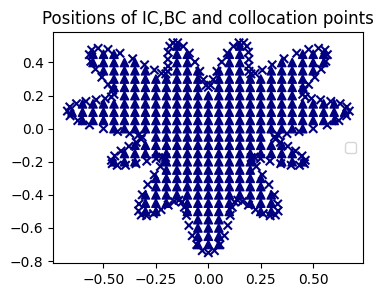

In [ ]:
fig = plt.figure(figsize=(4,3))
bc = jnp.zeros_like(yb)
dc = jnp.zeros_like(yd)
plt.scatter(xb, yb, c=bc, marker='x', vmin=0, vmax=1,cmap=cm.jet)
plt.scatter(xd, yd, c=dc, marker='^', vmin=0, vmax=2,cmap=cm.jet)
cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=0, vmax=1)
plt.title('Positions of IC,BC and collocation points');
#plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap))
plt.legend(loc='center right')

In [ ]:
def init_params(layers):
  keys = jax.random.split(jax.random.PRNGKey(0),len(layers)-1)
  params = list()
  for key,n_in,n_out in zip(keys,layers[:-1],layers[1:]):
    lb, ub = -(1 / jnp.sqrt(n_in)), (1 / jnp.sqrt(n_in)) # xavier initialization lower and upper bound
    W = lb + (ub-lb) * jax.random.uniform(key,shape=(n_in,n_out))
    B = jax.random.uniform(key,shape=(n_out,))
    params.append({'W':W,'B':B})
  return params

def fwd(params,t,x):
  X = jnp.concatenate([t,x],axis=1)
  *hidden,last = params
  for layer in hidden :
    X = jax.nn.tanh(X@layer['W']+layer['B'])
  return X@last['W'] + last['B']

@jax.jit
def MSE(true,pred):
  return jnp.mean((true-pred)**2)


def loss_fun(params,colloc,conds):
  x_c,y_c =colloc[:,[0]],colloc[:,[1]]
  ufunc = lambda x,y : fwd(params,x,y)

  loss =jnp.mean(PDE_loss(x_c,y_c,ufunc) **2)

  for cond in conds[0:4] :
    x_b,y_b,u_b = cond[:,[0]],cond[:,[1]],cond[:,[2]]
    loss += MSE(ufunc(x_b,y_b),u_b)


  return  loss

@jax.jit
def update(opt_state,params,colloc,conds):
  # Get the gradient w.r.t to MLP params
  grads=jax.jit(jax.grad(loss_fun,0))(params,colloc,conds)

  #Update params
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)

  return opt_state,params


In [ ]:
# construct the MLP of  6 hidden layers of 20 neurons for each layer
params = init_params([2]+[8]*4+[1])

In [ ]:
lr = optax.piecewise_constant_schedule(1e-2,{10_000:5e-3,30_000:1e-3,50_000:5e-4,70_000:1e-4})
optimizer = optax.adam(lr)
opt_state = optimizer.init(params)

In [ ]:
%%time
epochs = 10_000
for _ in range(epochs):
  opt_state,params = update(opt_state,params,colloc,conds)

  # print loss and epoch info
  if _ %(500) ==0:
    print(f'Epoch={_}\tloss={loss_fun(params,colloc,conds):.3e}')

Epoch=0	loss=7.041e+01
Epoch=500	loss=7.906e-02
Epoch=1000	loss=3.500e-02
Epoch=1500	loss=2.251e-02
Epoch=2000	loss=1.495e-02
Epoch=2500	loss=1.061e-02
Epoch=3000	loss=1.102e-01
Epoch=3500	loss=1.319e-02
Epoch=4000	loss=5.199e-03
Epoch=4500	loss=4.096e-03
Epoch=5000	loss=1.430e-02
Epoch=5500	loss=3.507e-03
Epoch=6000	loss=1.961e-03
Epoch=6500	loss=1.355e-03
Epoch=7000	loss=1.897e-02
Epoch=7500	loss=1.013e-03
Epoch=8000	loss=1.061e-03
Epoch=8500	loss=3.122e-03
Epoch=9000	loss=1.789e-03
Epoch=9500	loss=1.424e-03
CPU times: user 23.7 s, sys: 372 ms, total: 24 s
Wall time: 24.6 s


### Numerical solution

In [ ]:
pred = fwd(params,x,y)

infinity_norm = jnp.max(np.abs(pred - u(x,y)))
print(infinity_norm)

0.025427222


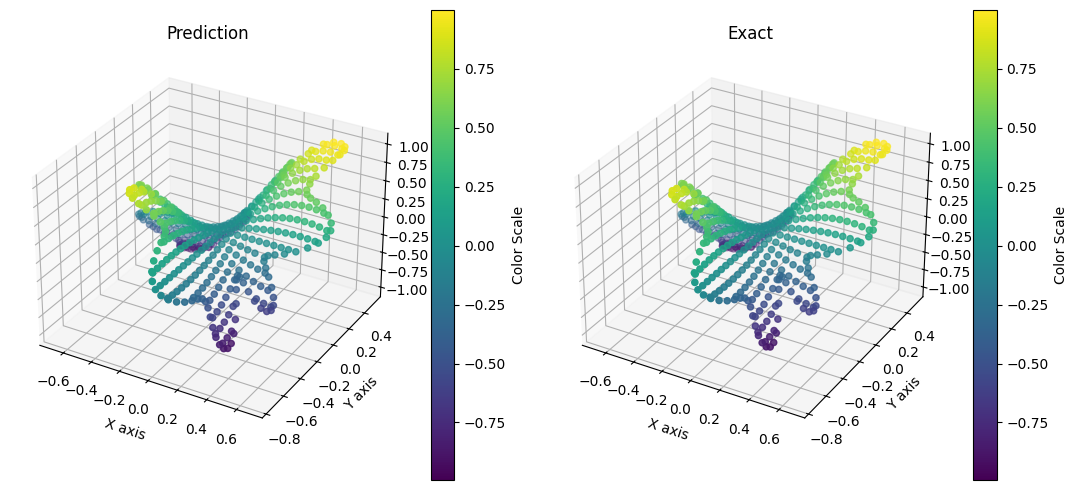

In [ ]:
# Create a 3D axis
fig, axes = plt.subplots(1, 2, figsize=(11, 5), subplot_kw={'projection': '3d'})
ax1 = axes[0]
scatter1 = ax1.scatter(x, y, pred, c=pred, cmap='viridis', label='3D Points')
fig.colorbar(scatter1, ax=ax1, label='Color Scale')
ax1.set_title('Prediction')
ax1.set_xlabel('X axis')
ax1.set_ylabel('Y axis')
ax1.set_zlabel('Predicted Values')


ax2 = axes[1]
scatter2 = ax2.scatter(x, y, u(x,y), c=pred, cmap='viridis', label='3D Points')
fig.colorbar(scatter2, ax=ax2, label='Color Scale')
ax2.set_title('Exact')
ax2.set_xlabel('X axis')
ax2.set_ylabel('Y axis')
ax2.set_zlabel('Predicted Values')
# Adjust layout for better spacing
plt.tight_layout()
# Show the plot
plt.show()

### Numerical solution